The data source is a Garmin Bike Computer   

The transformation related to time are
* adding timezone data to source data
* converting times to Dublin Time Zone
* producing a true time series with constant time interval of 1 second

## Setups

In [290]:
#Import Python Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree 
from datetime import datetime, timedelta
import os
import json
import pandas as pd
import numpy as np
from pytz import common_timezones, all_timezones, timezone

In [291]:
# Define name and path of data file
# This data file contains a sub-set of activiy information relating to speed and time

input_file = 'activity_898238015_10.csv'
input_dir = os.path.join("/", "opt","jupyter","data","csv" )
input_file_path = os.path.join(input_dir , input_file)

output_file = 'activity_898238015_20.csv'
output_dir = os.path.join("/", "opt","jupyter","data","csv" )
output_file_path = os.path.join(input_dir , output_file)



print ("Input file is (full path)  ", input_file_path)
print ("Output file is (full path)  ", output_file_path)

Input file is (full path)   /opt/jupyter/data/csv/activity_898238015_10.csv
Output file is (full path)   /opt/jupyter/data/csv/activity_898238015_20.csv


In [292]:
# Load data file into a Pandas data frame for inspection
# The dataframe is indexed on time - time variant data
df = pd.read_csv(input_file_path, index_col = 'time',  parse_dates=True)



# rename the speed column to speed_raw
#df.rename( columns = {"speed":"speed_raw"} , inplace=True)
#check column names
#df.columns

In [293]:
del df['Unnamed: 0']

In [294]:
df.head()

,altitude,cadence,distance,heart_rate,latitude,longitude
time,,,,,,
2015-09-13 06:25:51,79.400002,76,5.010000,103,53.363708,-6.190183
2015-09-13 06:25:56,90.800003,83,28.090000,106,53.363761,-6.190519
2015-09-13 06:25:57,90.800003,84,34.740002,106,53.363779,-6.190614
2015-09-13 06:26:00,90.800003,85,40.650002,108,53.363817,-6.190668
2015-09-13 06:26:03,90.800003,87,52.090000,110,53.363877,-6.190771


## Exploring the Imported Data Set

The fitness data consists of a set of data points whose values vary in time.
The data is a sequence in time order.

Each data point relates to a different point in time and contains the following variables:
* distince_diff - the distance travelled since the last data point
* time_diff - the number of seconds that have elapsed since the last data point
* speed_raw - measured in km/hr, calculated using formula (distance_diff / time_diff) * 3.6
* moving - if the data point represents movement then True.  If the user is at rest then False
* breaks - Set to True if the using is at rest and taking a break from activity

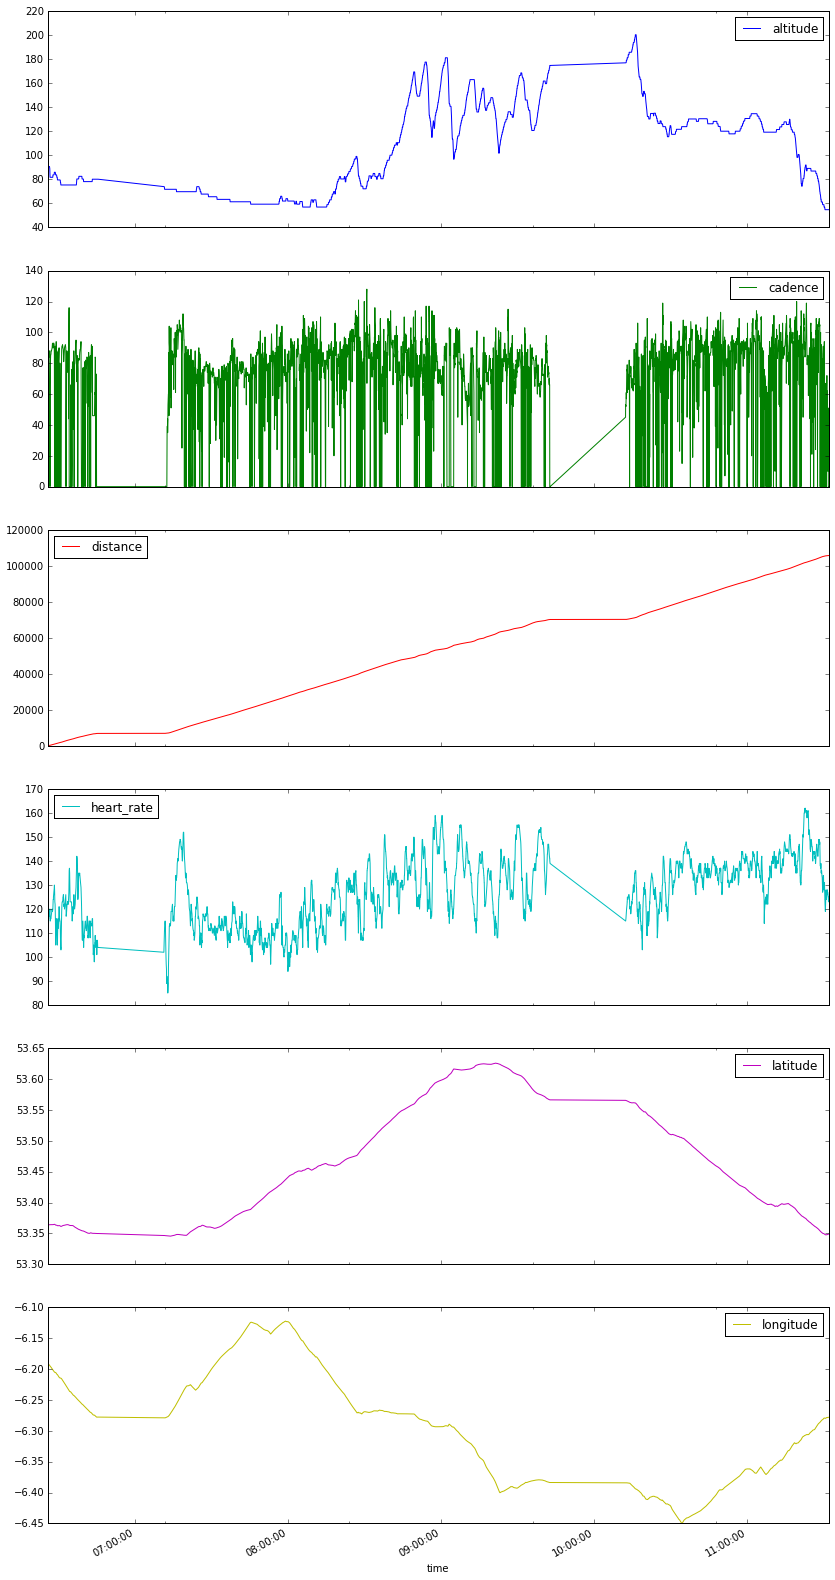

In [295]:
#plot all columns
_ = df.plot(
       subplots=True, 
        figsize=(14, 30),
         
        )

In [296]:
# get statistical summary
df.describe()

,altitude,cadence,distance,heart_rate,latitude,longitude
count,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000
mean,111.992968,65.096503,55305.131840,128.571348,53.491536,-6.301922
std,36.719490,35.178377,28127.615377,13.725037,0.093893,0.083439
min,54.799999,0.000000,5.010000,85.000000,53.345526,-6.449606
25%,78.199997,55.000000,35449.244141,118.000000,53.397380,-6.381119
50%,119.599998,78.000000,56192.808594,129.000000,53.495561,-6.293268
75%,137.800003,89.000000,74205.464844,139.000000,53.577163,-6.258500
max,200.600006,128.000000,105730.960938,162.000000,53.625859,-6.122161


## Exploring the Time Interval between Data Points

Inspection of the first few rows shows that the data is time indexed.   
The time_diff column shows that the intervals between data points are whole seconds.    
The time interval between data points is not fixed - irregular interval between data points
For example there are 5 seconds between first and second data points.

### Time Difference Calculations

In [297]:
# based on index work out time difference in seconds
# default missing time difference (expecially first position) to 1 second
df['time_diff'] = df.index.to_series().diff().fillna(1).apply( lambda x: int( x / np.timedelta64(1, 's') ) )
df.describe()

,altitude,cadence,distance,heart_rate,latitude,longitude,time_diff
count,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000
mean,111.992968,65.096503,55305.131840,128.571348,53.491536,-6.301922,3.435945
std,36.719490,35.178377,28127.615377,13.725037,0.093893,0.083439,32.228964
min,54.799999,0.000000,5.010000,85.000000,53.345526,-6.449606,1.000000
25%,78.199997,55.000000,35449.244141,118.000000,53.397380,-6.381119,1.000000
50%,119.599998,78.000000,56192.808594,129.000000,53.495561,-6.293268,1.000000
75%,137.800003,89.000000,74205.464844,139.000000,53.577163,-6.258500,4.000000
max,200.600006,128.000000,105730.960938,162.000000,53.625859,-6.122161,1775.000000


In [298]:
# view first few rows 
df.head()

,altitude,cadence,distance,heart_rate,latitude,longitude,time_diff
time,,,,,,,
2015-09-13 06:25:51,79.400002,76,5.010000,103,53.363708,-6.190183,1
2015-09-13 06:25:56,90.800003,83,28.090000,106,53.363761,-6.190519,5
2015-09-13 06:25:57,90.800003,84,34.740002,106,53.363779,-6.190614,1
2015-09-13 06:26:00,90.800003,85,40.650002,108,53.363817,-6.190668,3
2015-09-13 06:26:03,90.800003,87,52.090000,110,53.363877,-6.190771,3


The histogram below shows that most common time interval between data points is 1 second. However many data points have multiple seconds between data points.

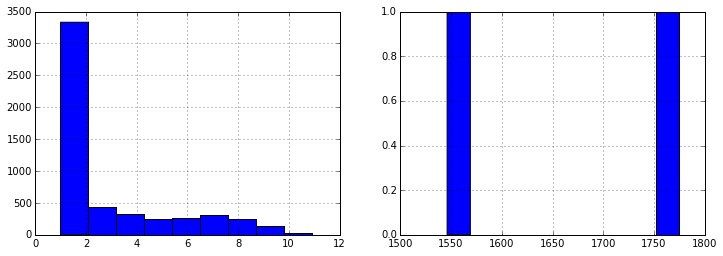

In [299]:
# plotting the time interval betwe

plt.figure() 
plt.subplot(1,2,1)
_ = df['time_diff'][df['time_diff'] < 600].hist(figsize=(12,4))
plt.subplot(1,2,2)
_ = df['time_diff'][df['time_diff'] > 600].hist(figsize=(12,4))

## Add a breaks columns
note ths column is call breaks because break is a Python keyword

In [300]:
df['breaks'] = (df['time_diff'] > 600)
df[ (df['time_diff'] > 100) ]

,altitude,cadence,distance,heart_rate,latitude,longitude,time_diff,breaks
time,,,,,,,,
2015-09-13 07:11:26,74.000000,0,6910.580078,102,53.346748,-6.278896,1546,True
2015-09-13 10:12:23,177.199997,45,70205.281250,115,53.565620,-6.384032,1775,True


## Transforming the Data Set to a Time Series
In this section a new dataframs is constructed with a constant frequency of 1 second.   
In the new dataframe there is exactly 1 second between all data points.
There are no missing data points - a row is generated for every second from start to end time

In [301]:
# create a new dataframe from original dataframe with a constant frequency of one second
time_series = df.asfreq(freq='S', )
time_series.head(10)

,altitude,cadence,distance,heart_rate,latitude,longitude,time_diff,breaks
time,,,,,,,,
2015-09-13 06:25:51,79.400002,76,5.010000,103,53.363708,-6.190183,1,False
2015-09-13 06:25:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:56,90.800003,83,28.090000,106,53.363761,-6.190519,5,False
2015-09-13 06:25:57,90.800003,84,34.740002,106,53.363779,-6.190614,1,False
2015-09-13 06:25:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Break Data
Creating the time series , creates lots of new data points
Issue is that there is no data for these data points, only an index
As a result of creating the time series, there are now many data points missing data

In [302]:
# First backfill the data in the Breaks column
time_series.breaks.fillna(method = 'bfill', inplace=True)
time_series.time_diff.fillna(0, inplace=True)
time_series.head(10)

,altitude,cadence,distance,heart_rate,latitude,longitude,time_diff,breaks
time,,,,,,,,
2015-09-13 06:25:51,79.400002,76,5.010000,103,53.363708,-6.190183,1,False
2015-09-13 06:25:52,NaN,NaN,NaN,NaN,NaN,NaN,0,False
2015-09-13 06:25:53,NaN,NaN,NaN,NaN,NaN,NaN,0,False
2015-09-13 06:25:54,NaN,NaN,NaN,NaN,NaN,NaN,0,False
2015-09-13 06:25:55,NaN,NaN,NaN,NaN,NaN,NaN,0,False
2015-09-13 06:25:56,90.800003,83,28.090000,106,53.363761,-6.190519,5,False
2015-09-13 06:25:57,90.800003,84,34.740002,106,53.363779,-6.190614,1,False
2015-09-13 06:25:58,NaN,NaN,NaN,NaN,NaN,NaN,0,False
2015-09-13 06:25:59,NaN,NaN,NaN,NaN,NaN,NaN,0,False


### Backfill using Interpolate

In [303]:
time_series.interpolate(inplace=True)

In [304]:
time_series.head(10)

,altitude,cadence,distance,heart_rate,latitude,longitude,time_diff,breaks
time,,,,,,,,
2015-09-13 06:25:51,79.400002,76.000000,5.010000,103.000000,53.363708,-6.190183,1,False
2015-09-13 06:25:52,81.680002,77.400000,9.626000,103.600000,53.363718,-6.190250,0,False
2015-09-13 06:25:53,83.960002,78.800000,14.242000,104.200000,53.363729,-6.190317,0,False
2015-09-13 06:25:54,86.240002,80.200000,18.858000,104.800000,53.363740,-6.190384,0,False
2015-09-13 06:25:55,88.520003,81.600000,23.474000,105.400000,53.363750,-6.190451,0,False
2015-09-13 06:25:56,90.800003,83.000000,28.090000,106.000000,53.363761,-6.190519,5,False
2015-09-13 06:25:57,90.800003,84.000000,34.740002,106.000000,53.363779,-6.190614,1,False
2015-09-13 06:25:58,90.800003,84.333333,36.710002,106.666667,53.363792,-6.190632,0,False
2015-09-13 06:25:59,90.800003,84.666667,38.680002,107.333333,53.363804,-6.190650,0,False


In [305]:
def set_breaks_altitude(row):
    column_name = 'altitude'
    if  row['breaks'] == True and row['time_diff'] > 1:
        return row[column_name]
    elif row['breaks'] == False:
        return row[column_name]
    else:
        return np.nan    
    
def set_breaks_distance(row):
    column_name = 'distance'
    if  row['breaks'] == True and row['time_diff'] > 1:
        return row[column_name]
    elif row['breaks'] == False:
        return row[column_name]
    else:
        return np.nan
    
def set_breaks_heart_rate(row):
    column_name = 'heart_rate'
    if  row['breaks'] == True and row['time_diff'] > 1:
        return row[column_name]
    elif row['breaks'] == False:
        return row[column_name]
    else:
        return np.nan    
    
def set_breaks_latitude(row):
    column_name = 'latitude'
    if  row['breaks'] == True and row['time_diff'] > 1:
        return row[column_name]
    elif row['breaks'] == False:
        return row[column_name]
    else:
        return np.nan
    
def set_breaks_longitude(row):
    column_name = 'longitude'
    if  row['breaks'] == True and row['time_diff'] > 1:
        return row[column_name]
    elif row['breaks'] == False:
        return row[column_name]
    else:
        return np.nan
    
def set_breaks_cadence(row):
    column_name = 'cadence'
    if  row['breaks'] == True:
        return 0
    else:
        return row[column_name]

In [306]:
time_series.altitude = time_series.apply(set_breaks_altitude, axis=1)
time_series.distance = time_series.apply(set_breaks_distance, axis=1)
time_series.heart_rate = time_series.apply(set_breaks_heart_rate, axis=1)
time_series.longitude = time_series.apply(set_breaks_longitude, axis=1)
time_series.latitude = time_series.apply(set_breaks_latitude, axis=1)
time_series.cadence = time_series.apply(set_breaks_cadence, axis=1)

In [307]:
time_series[time_series.breaks].tail()

,altitude,cadence,distance,heart_rate,latitude,longitude,time_diff,breaks
time,,,,,,,,
2015-09-13 10:12:19,NaN,0,NaN,NaN,NaN,NaN,0,True
2015-09-13 10:12:20,NaN,0,NaN,NaN,NaN,NaN,0,True
2015-09-13 10:12:21,NaN,0,NaN,NaN,NaN,NaN,0,True
2015-09-13 10:12:22,NaN,0,NaN,NaN,NaN,NaN,0,True
2015-09-13 10:12:23,177.199997,0,70205.28125,115,53.56562,-6.384032,1775,True


In [308]:
time_series.fillna(method = 'bfill', inplace=True)

In [309]:
time_series.cadence = time_series.cadence.round().astype('int')
time_series.heart_rate = time_series.heart_rate.round().astype('int')

In [310]:
time_series.dtypes

altitude      float64
cadence         int64
distance      float64
heart_rate      int64
latitude      float64
longitude     float64
time_diff     float64
breaks           bool
dtype: object

In [311]:
#label the index, give it name 'time'
#time_series.index.name = 'time'

In [312]:
time_series.to_csv(output_file_path)